In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import joblib
import warnings
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [ ]:
# Make TF quiet and force python protobuf impl BEFORE importing TF (no internet install)
import os, importlib, importlib.util
from pathlib import Path
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

IN_KAGGLE = Path('/kaggle/input').exists()

# Deterministic availability detection (no try/except)
LGBM_AVAILABLE = importlib.util.find_spec("lightgbm") is not None
# To avoid protobuf/TF mismatches in Kaggle's offline runner, hard-disable TF on Kaggle
LSTM_AVAILABLE = (not IN_KAGGLE) and (importlib.util.find_spec("tensorflow") is not None)

# Import only when available per above policy
if LGBM_AVAILABLE:
    import lightgbm as lgb

if LSTM_AVAILABLE:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping

print(f"IN_KAGGLE={IN_KAGGLE}, LGBM_AVAILABLE={LGBM_AVAILABLE}, LSTM_AVAILABLE={LSTM_AVAILABLE}")

## Configuration

In [ ]:
# Get project directory
NOTEBOOK_DIR = Path.cwd()
PROJECT_DIR = NOTEBOOK_DIR.parent

# Detect Kaggle environment and set paths accordingly
IN_KAGGLE = Path('/kaggle/input').exists()


def resolve_kaggle_path(preferred: Path, default_filename: str) -> Path:
    """Resolve a data path when running on Kaggle.
    Priority:
    1) Environment variable override (e.g., TRAIN_PATH/TEST_PATH)
    2) /kaggle/input/**/<default_filename>
    3) First CSV found under /kaggle/input
    4) Fallback to preferred path
    """
    if not IN_KAGGLE:
        return preferred

    # Environment override, e.g., TRAIN_PATH or TEST_PATH
    env_key = default_filename.upper().replace('.CSV', '') + '_PATH'
    env_val = os.environ.get(env_key)
    if env_val and Path(env_val).exists():
        return Path(env_val)

    # Try the standard filename within any dataset mounted in /kaggle/input
    candidates = list(Path('/kaggle/input').glob(f'**/{default_filename}'))
    if candidates:
        return candidates[0]

    # Fallback: any CSV under /kaggle/input
    any_csv = list(Path('/kaggle/input').glob('**/*.csv'))
    if any_csv:
        print(f"Warning: Could not find {default_filename}; using first CSV found: {any_csv[0]}")
        return any_csv[0]

    # Last resort
    print(f"Warning: No CSV found under /kaggle/input; attempting preferred path: {preferred}")
    return preferred

# Directories for artifacts/results (writeable on Kaggle: /kaggle/working)
if IN_KAGGLE:
    ARTIFACTS_DIR = Path('/kaggle/working/artifacts')
    RESULTS_DIR = Path('/kaggle/working/results')
else:
    ARTIFACTS_DIR = PROJECT_DIR / 'artifacts'
    RESULTS_DIR = PROJECT_DIR / 'results'

# Configuration
CONFIG = {
    'train_data_path': resolve_kaggle_path(PROJECT_DIR / 'data' / 'train.csv', 'train.csv'),
    'test_data_path': resolve_kaggle_path(PROJECT_DIR / 'data' / 'test.csv', 'test.csv'),
    'artifacts_dir': ARTIFACTS_DIR,
    'results_dir': RESULTS_DIR,
    'target_column': 'forward_returns',
    'prediction_bounds': (0.0, 2.0),
    'max_volatility_ratio': 1.2,  # 120% of benchmark
    'n_splits': 5,  # For time-series cross-validation
}

# Ensure results/artifacts directories exist
CONFIG['results_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['artifacts_dir'].mkdir(parents=True, exist_ok=True)

# Feature list (same as Step 1)
FEATURE_COLS = [
    'V7', 'V13', 'E3', 'M4', 'P11', 'S2', 'I7', 'P2', 'P6', 'E17',
    'M12', 'M11', 'E2', 'I2', 'E9', 'P8', 'P5', 'I5', 'I9', 'V12'
]

## Load and Prepare Data

In [ ]:
# Load training data
train_df = pd.read_csv(CONFIG['train_data_path'])
print(f"Loaded training data: {train_df.shape} from {CONFIG['train_data_path']}")
# Safely detect a date column before accessing it to avoid KeyError
date_col = next((c for c in ['date','timestamp','datetime','time','Date','DATE'] if c in train_df.columns), None)
if date_col:
    date_min = pd.to_datetime(train_df[date_col], errors='coerce').min()
    date_max = pd.to_datetime(train_df[date_col], errors='coerce').max()
    if pd.notna(date_min) and pd.notna(date_max):
        print(f"Date range ({date_col}): {date_min} to {date_max}")

Loaded training data: (9021, 98)


In [ ]:
# Data preparation
X = train_df[FEATURE_COLS].copy()
y = train_df[CONFIG['target_column']].copy()
# Safely build a `dates` series from available date-like columns
date_col = next((c for c in ['date','timestamp','datetime','time','Date','DATE'] if c in train_df.columns), None)
if date_col:
    dates = pd.to_datetime(train_df[date_col], errors='coerce')
else:
    dates = pd.Series(pd.NaT, index=train_df.index)

# Handle missing values
X = X.ffill().bfill()

# Remove rows with NaN
valid_idx = ~(X.isnull().any(axis=1) | y.isnull())
X = X[valid_idx]
y = y[valid_idx]
dates = dates[valid_idx]

print(f"Data cleaned: {len(X):,} samples")

Data cleaned: 9,021 samples


## Time-Series Cross-Validation Setup

Using **Walk-Forward** validation to respect temporal ordering.

In [14]:
# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=CONFIG['n_splits'])

## Model 1: Random Forest Regressor

In [15]:
print("\n" + "="*70)
print("MODEL 1: RANDOM FOREST")
print("="*70)

rf_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    print(f"\nFold {fold}/{CONFIG['n_splits']}")
    
    # Split data
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Train Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train_fold)
    
    # Predict
    y_pred = rf_model.predict(X_val_scaled)
    
    # Clip predictions to valid range
    y_pred = np.clip(y_pred, CONFIG['prediction_bounds'][0], CONFIG['prediction_bounds'][1])
    
    # Evaluate
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    
    rf_results.append({
        'fold': fold,
        'mse': mse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.6f}")

# Average results
rf_results_df = pd.DataFrame(rf_results)
print(f"\n{'='*50}")
print("RANDOM FOREST - AVERAGE RESULTS")
print(f"{'='*50}")
print(f"MSE: {rf_results_df['mse'].mean():.6f} ± {rf_results_df['mse'].std():.6f}")
print(f"MAE: {rf_results_df['mae'].mean():.6f} ± {rf_results_df['mae'].std():.6f}")
print(f"R²:  {rf_results_df['r2'].mean():.6f} ± {rf_results_df['r2'].std():.6f}")


MODEL 1: RANDOM FOREST

Fold 1/5
  MSE: 0.000148
  MAE: 0.009316
  R²: -0.014001

Fold 2/5
  MSE: 0.000105
  MAE: 0.007374
  R²: -0.080307

Fold 3/5
  MSE: 0.000105
  MAE: 0.007374
  R²: -0.080307

Fold 3/5
  MSE: 0.000177
  MAE: 0.009373
  R²: -0.018052

Fold 4/5
  MSE: 0.000177
  MAE: 0.009373
  R²: -0.018052

Fold 4/5
  MSE: 0.000069
  MAE: 0.005733
  R²: -0.016737

Fold 5/5
  MSE: 0.000069
  MAE: 0.005733
  R²: -0.016737

Fold 5/5
  MSE: 0.000131
  MAE: 0.008184
  R²: -0.020799

RANDOM FOREST - AVERAGE RESULTS
MSE: 0.000126 ± 0.000041
MAE: 0.007996 ± 0.001515
R²:  -0.029979 ± 0.028240


In [16]:
# Train final Random Forest on all data
print("\nTraining final Random Forest on all data...")

scaler_rf = StandardScaler()
X_scaled = scaler_rf.fit_transform(X)

rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_scaled, y)

# Save model
joblib.dump(rf_final, CONFIG['artifacts_dir'] / 'rf_model.joblib')
joblib.dump(scaler_rf, CONFIG['artifacts_dir'] / 'rf_scaler.joblib')

print("Random Forest model saved")


Training final Random Forest on all data...
Random Forest model saved
Random Forest model saved


## Model 2: LightGBM

In [17]:
if LGBM_AVAILABLE:
    print("\n" + "="*70)
    print("MODEL 2: LIGHTGBM")
    print("="*70)
    
    lgbm_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        print(f"\nFold {fold}/{CONFIG['n_splits']}")
        
        # Split data
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train LightGBM
        lgbm_model = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=5,
            num_leaves=31,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        )
        lgbm_model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
        )
        
        # Predict
        y_pred = lgbm_model.predict(X_val_fold)
        y_pred = np.clip(y_pred, CONFIG['prediction_bounds'][0], CONFIG['prediction_bounds'][1])
        
        # Evaluate
        mse = mean_squared_error(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        
        lgbm_results.append({
            'fold': fold,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })
        
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  R²: {r2:.6f}")
    
    # Average results
    lgbm_results_df = pd.DataFrame(lgbm_results)
    print(f"\n{'='*50}")
    print("LIGHTGBM - AVERAGE RESULTS")
    print(f"{'='*50}")
    print(f"MSE: {lgbm_results_df['mse'].mean():.6f} ± {lgbm_results_df['mse'].std():.6f}")
    print(f"MAE: {lgbm_results_df['mae'].mean():.6f} ± {lgbm_results_df['mae'].std():.6f}")
    print(f"R²:  {lgbm_results_df['r2'].mean():.6f} ± {lgbm_results_df['r2'].std():.6f}")
else:
    print("Skipping LightGBM (not installed)")


MODEL 2: LIGHTGBM

Fold 1/5
  MSE: 0.000146
  MAE: 0.009297
  R²: 0.000190

Fold 2/5
  MSE: 0.000098
  MAE: 0.007094
  R²: -0.001380

Fold 3/5
  MSE: 0.000173
  MAE: 0.009303
  R²: 0.002569

Fold 4/5
  MSE: 0.000067
  MAE: 0.005709
  R²: 0.001291

Fold 5/5
  MSE: 0.000129
  MAE: 0.008121
  R²: -0.000352

LIGHTGBM - AVERAGE RESULTS
MSE: 0.000123 ± 0.000041
MAE: 0.007905 ± 0.001535
R²:  0.000464 ± 0.001521
  MSE: 0.000129
  MAE: 0.008121
  R²: -0.000352

LIGHTGBM - AVERAGE RESULTS
MSE: 0.000123 ± 0.000041
MAE: 0.007905 ± 0.001535
R²:  0.000464 ± 0.001521


In [18]:
if LGBM_AVAILABLE:
    # Train final LightGBM on all data
    print("\nTraining final LightGBM on all data...")
    
    lgbm_final = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    lgbm_final.fit(X, y)
    
    # Save model
    joblib.dump(lgbm_final, CONFIG['artifacts_dir'] / 'lgbm_model.joblib')
    
    print("LightGBM model saved")


Training final LightGBM on all data...
LightGBM model saved
LightGBM model saved


## Model 3: LSTM (Deep Learning)

In [19]:
if LSTM_AVAILABLE:
    print("\n" + "="*70)
    print("MODEL 3: LSTM")
    print("="*70)
    
    # Prepare data for LSTM (need 3D input: samples, timesteps, features)
    # We'll use a simple approach: each sample is a single timestep
    
    lstm_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        print(f"\nFold {fold}/{CONFIG['n_splits']}")
        
        # Split data
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Reshape for LSTM (samples, timesteps, features)
        X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
        
        # Build LSTM model
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(1, len(FEATURE_COLS)), return_sequences=True),
            Dropout(0.2),
            LSTM(25, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
        
        # Train
        history = model.fit(
            X_train_lstm, y_train_fold,
            validation_data=(X_val_lstm, y_val_fold),
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predict
        y_pred = model.predict(X_val_lstm, verbose=0).flatten()
        y_pred = np.clip(y_pred, CONFIG['prediction_bounds'][0], CONFIG['prediction_bounds'][1])
        
        # Evaluate
        mse = mean_squared_error(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        
        lstm_results.append({
            'fold': fold,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })
        
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  R²: {r2:.6f}")
        print(f"  Epochs trained: {len(history.history['loss'])}")
    
    # Average results
    lstm_results_df = pd.DataFrame(lstm_results)
    print(f"\n{'='*50}")
    print("LSTM - AVERAGE RESULTS")
    print(f"{'='*50}")
    print(f"MSE: {lstm_results_df['mse'].mean():.6f} ± {lstm_results_df['mse'].std():.6f}")
    print(f"MAE: {lstm_results_df['mae'].mean():.6f} ± {lstm_results_df['mae'].std():.6f}")
    print(f"R²:  {lstm_results_df['r2'].mean():.6f} ± {lstm_results_df['r2'].std():.6f}")
else:
    print("Skipping LSTM (TensorFlow not installed)")


MODEL 3: LSTM

Fold 1/5
  MSE: 0.000261
  MAE: 0.011765
  R²: -0.785772
  Epochs trained: 13

Fold 2/5
  MSE: 0.000261
  MAE: 0.011765
  R²: -0.785772
  Epochs trained: 13

Fold 2/5
  MSE: 0.000097
  MAE: 0.007091
  R²: 0.003345
  Epochs trained: 37

Fold 3/5
  MSE: 0.000097
  MAE: 0.007091
  R²: 0.003345
  Epochs trained: 37

Fold 3/5
  MSE: 0.000316
  MAE: 0.013467
  R²: -0.824913
  Epochs trained: 25

Fold 4/5
  MSE: 0.000316
  MAE: 0.013467
  R²: -0.824913
  Epochs trained: 25

Fold 4/5
  MSE: 0.000067
  MAE: 0.005727
  R²: 0.000429
  Epochs trained: 15

Fold 5/5
  MSE: 0.000067
  MAE: 0.005727
  R²: 0.000429
  Epochs trained: 15

Fold 5/5
  MSE: 0.000127
  MAE: 0.008092
  R²: 0.011495
  Epochs trained: 14

LSTM - AVERAGE RESULTS
MSE: 0.000174 ± 0.000109
MAE: 0.009228 ± 0.003260
R²:  -0.319083 ± 0.444126
  MSE: 0.000127
  MAE: 0.008092
  R²: 0.011495
  Epochs trained: 14

LSTM - AVERAGE RESULTS
MSE: 0.000174 ± 0.000109
MAE: 0.009228 ± 0.003260
R²:  -0.319083 ± 0.444126


In [20]:
if LSTM_AVAILABLE:
    # Train final LSTM on all data
    print("\nTraining final LSTM on all data...")
    
    scaler_lstm = StandardScaler()
    X_scaled = scaler_lstm.fit_transform(X)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    lstm_final = Sequential([
        LSTM(50, activation='relu', input_shape=(1, len(FEATURE_COLS)), return_sequences=True),
        Dropout(0.2),
        LSTM(25, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    lstm_final.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
    lstm_final.fit(
        X_lstm, y,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Save model
    lstm_final.save(CONFIG['artifacts_dir'] / 'lstm_model.h5')
    joblib.dump(scaler_lstm, CONFIG['artifacts_dir'] / 'lstm_scaler.joblib')
    
    print("LSTM model saved")


Training final LSTM on all data...


LSTM model saved


## Model Comparison

In [24]:
# Compare all models
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

comparison = []

# Random Forest
comparison.append({
    'Model': 'Random Forest',
    'MSE': f"{rf_results_df['mse'].mean():.6f} ± {rf_results_df['mse'].std():.6f}",
    'MAE': f"{rf_results_df['mae'].mean():.6f} ± {rf_results_df['mae'].std():.6f}",
    'R²': f"{rf_results_df['r2'].mean():.6f} ± {rf_results_df['r2'].std():.6f}"
})

# LightGBM
if LGBM_AVAILABLE:
    comparison.append({
        'Model': 'LightGBM',
        'MSE': f"{lgbm_results_df['mse'].mean():.6f} ± {lgbm_results_df['mse'].std():.6f}",
        'MAE': f"{lgbm_results_df['mae'].mean():.6f} ± {lgbm_results_df['mae'].std():.6f}",
        'R²': f"{lgbm_results_df['r2'].mean():.6f} ± {lgbm_results_df['r2'].std():.6f}"
    })

# LSTM
if LSTM_AVAILABLE:
    comparison.append({
        'Model': 'LSTM',
        'MSE': f"{lstm_results_df['mse'].mean():.6f} ± {lstm_results_df['mse'].std():.6f}",
        'MAE': f"{lstm_results_df['mae'].mean():.6f} ± {lstm_results_df['mae'].std():.6f}",
        'R²': f"{lstm_results_df['r2'].mean():.6f} ± {lstm_results_df['r2'].std():.6f}"
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(CONFIG['results_dir'] / 'model_comparison.csv', index=False)


MODEL COMPARISON SUMMARY
        Model                 MSE                 MAE                   R²
Random Forest 0.000126 ± 0.000041 0.007996 ± 0.001515 -0.029979 ± 0.028240
     LightGBM 0.000123 ± 0.000041 0.007905 ± 0.001535  0.000464 ± 0.001521
         LSTM 0.000174 ± 0.000109 0.009228 ± 0.003260 -0.319083 ± 0.444126


## Volatility Check

Ensure predictions don't exceed 120% of benchmark volatility.

In [25]:
# Calculate volatility of predictions vs target
print("\n" + "="*70)
print("VOLATILITY ANALYSIS")
print("="*70)

# Get predictions from best model (Random Forest for now)
X_scaled_all = scaler_rf.transform(X)
predictions = rf_final.predict(X_scaled_all)
predictions = np.clip(predictions, CONFIG['prediction_bounds'][0], CONFIG['prediction_bounds'][1])

# Calculate volatilities
target_vol = y.std()
pred_vol = predictions.std()
vol_ratio = pred_vol / target_vol

print(f"Target (benchmark) volatility: {target_vol:.6f}")
print(f"Prediction volatility: {pred_vol:.6f}")
print(f"Volatility ratio: {vol_ratio:.2%}")
print(f"Max allowed ratio: {CONFIG['max_volatility_ratio']:.0%}")

if vol_ratio <= CONFIG['max_volatility_ratio']:
    print(f"Volatility constraint satisfied")
else:
    print(f"Warning: Volatility exceeds {CONFIG['max_volatility_ratio']:.0%} threshold")


VOLATILITY ANALYSIS
Target (benchmark) volatility: 0.010541
Prediction volatility: 0.001284
Volatility ratio: 12.18%
Max allowed ratio: 120%
Volatility constraint satisfied


## Feature Importance (Random Forest)


TOP 10 MOST IMPORTANT FEATURES (Random Forest)
feature  importance
     M4    0.127265
     P8    0.077283
    E17    0.075593
    V13    0.073020
     V7    0.069702
     P6    0.060576
     I2    0.056485
    M11    0.051198
     P5    0.050878
    P11    0.050763


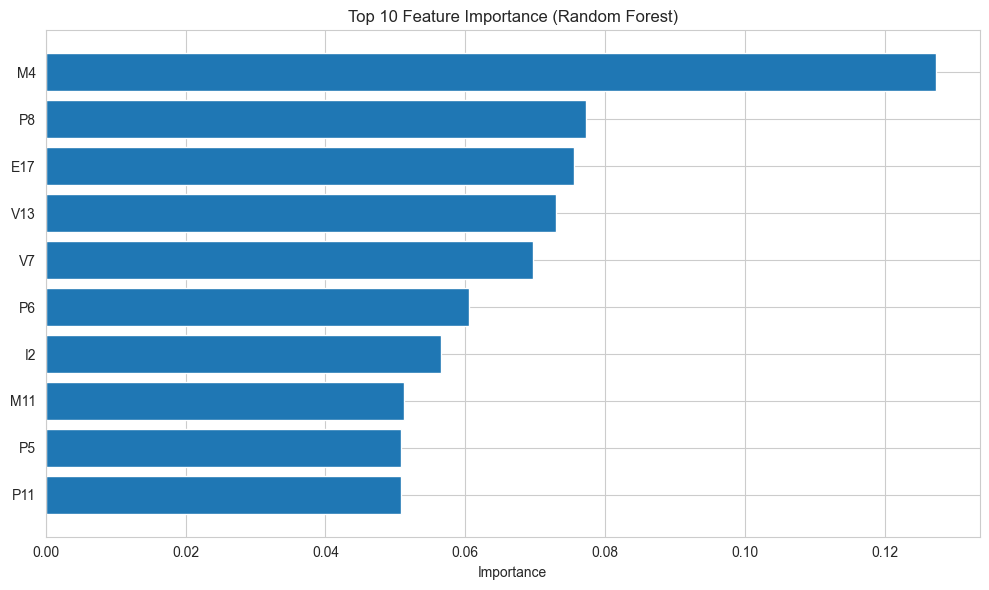

In [26]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
print("="*70)
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(CONFIG['results_dir'] / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Generate submission file for Kaggle Competition
from pathlib import Path

print("\n" + "="*70)
print("GENERATING SUBMISSION FILE")
print("="*70)

# Force Kaggle path detection
IS_KAGGLE = Path('/kaggle/input').exists()
print(f"Environment: {'KAGGLE' if IS_KAGGLE else 'LOCAL'}")

# Always use /kaggle/working on Kaggle, results dir locally  
if IS_KAGGLE:
    submission_path = Path('/kaggle/working/submission.csv')
else:
    submission_path = CONFIG['results_dir'] / 'submission.csv'

print(f"Submission will be saved to: {submission_path}")

# Load test data and generate predictions
test_path = CONFIG['test_data_path']
print(f"Looking for test data at: {test_path}")

if not Path(test_path).exists():
    print(f"ERROR: Test file not found!")
    raise FileNotFoundError(f"Cannot create submission without test data at {test_path}")

test_df = pd.read_csv(test_path)
print(f"✓ Loaded test data: {test_df.shape}")

# Verify all required features are present
missing = [c for c in FEATURE_COLS if c not in test_df.columns]
if missing:
    raise ValueError(f"Test data missing required features: {missing}")

# Prepare test features
X_test = test_df[FEATURE_COLS].copy().ffill().bfill()
X_test_scaled = scaler_rf.transform(X_test)

# Generate predictions using Random Forest
test_pred = rf_final.predict(X_test_scaled)
test_pred = np.clip(test_pred, CONFIG['prediction_bounds'][0], CONFIG['prediction_bounds'][1])
print(f"✓ Generated {len(test_pred)} predictions")

# Create submission DataFrame - check for sample_submission to get correct format
sample_sub_path = Path('/kaggle/input/hull-tactical-market-prediction/sample_submission.csv')
if sample_sub_path.exists():
    print(f"✓ Found sample_submission.csv")
    sample_sub = pd.read_csv(sample_sub_path)
    id_col = sample_sub.columns[0]
    print(f"  Using ID column: '{id_col}'")
    submission_df = pd.DataFrame({
        id_col: test_df[id_col] if id_col in test_df.columns else range(len(test_df)),
        'prediction': test_pred
    })
elif 'id' in test_df.columns:
    print(f"  Using 'id' column from test data")
    submission_df = pd.DataFrame({'id': test_df['id'], 'prediction': test_pred})
else:
    print(f"  Using 'row' as ID column")
    submission_df = pd.DataFrame({'row': np.arange(len(test_df)), 'prediction': test_pred})

# Save submission file
submission_df.to_csv(submission_path, index=False)
print(f"✓ Submission saved: {submission_path}")
print(f"  Shape: {submission_df.shape}")
print(f"  Prediction range: [{test_pred.min():.6f}, {test_pred.max():.6f}]")

# Verify file was written
if submission_path.exists():
    size = submission_path.stat().st_size
    print(f"✓ File verified: {size:,} bytes")
else:
    raise FileNotFoundError(f"Failed to write submission file to {submission_path}")

# Verify all output files exist
print("\nVerifying output files:")
expected = [
    submission_path,
    CONFIG['artifacts_dir'] / 'rf_model.joblib',
    CONFIG['artifacts_dir'] / 'rf_scaler.joblib',
    CONFIG['results_dir'] / 'feature_importance.png',
    CONFIG['results_dir'] / 'model_comparison.csv',
]

for p in expected:
    exists = Path(p).exists()
    size = Path(p).stat().st_size if exists else 0
    status = '✓' if exists else '✗'
    print(f"  {p.name}: {status} ({size:,} bytes)")


In [ ]:
# Final confirmation and Kaggle output declaration
print("\n" + "="*70)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*70)

# CRITICAL: Ensure submission file is in the correct location for Kaggle
# Check BOTH possible locations since path logic might be wrong
kaggle_submission = Path('/kaggle/working/submission.csv')
local_submission = CONFIG['results_dir'] / 'submission.csv'

# Find where the file actually is
if kaggle_submission.exists():
    submission_file = kaggle_submission
    print(f"✓ Submission file found at: {submission_file}")
elif local_submission.exists():
    submission_file = local_submission
    print(f"WARNING: Submission file at wrong location: {submission_file}")
    # Copy to correct Kaggle location if we're on Kaggle
    if Path('/kaggle/working').exists():
        import shutil
        shutil.copy(submission_file, kaggle_submission)
        submission_file = kaggle_submission
        print(f"✓ Copied to correct location: {submission_file}")
else:
    print(f"✗ ERROR: Submission file not found at either location:")
    print(f"  - {kaggle_submission}")
    print(f"  - {local_submission}")
    raise FileNotFoundError(f"Submission file not created!")

print(f"Size: {submission_file.stat().st_size:,} bytes")

# Read and validate submission
sub_df = pd.read_csv(submission_file)
print(f"Shape: {sub_df.shape}")
print(f"Columns: {list(sub_df.columns)}")
print("\nFirst 5 rows:")
print(sub_df.head())

# Validate submission format
if sub_df.shape[0] == 0:
    raise ValueError("Submission file is empty!")
if sub_df.isnull().any().any():
    raise ValueError("Submission contains null values!")

print(f"\n✓ Submission file validated successfully")
print(f"✓ Ready for Kaggle competition submission")
print(f"\n** SUBMISSION FILE LOCATION: {submission_file.absolute()} **")
